
# Model Optimization


In [37]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from deap import base, creator, tools, algorithms
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

data = pd.read_csv("../data/processed/scaled_results/Employee_MedianMode_imputed_standard_scaled.csv")

X = data.drop(columns=['LeaveOrNot'])
y = data['LeaveOrNot'].astype(int)

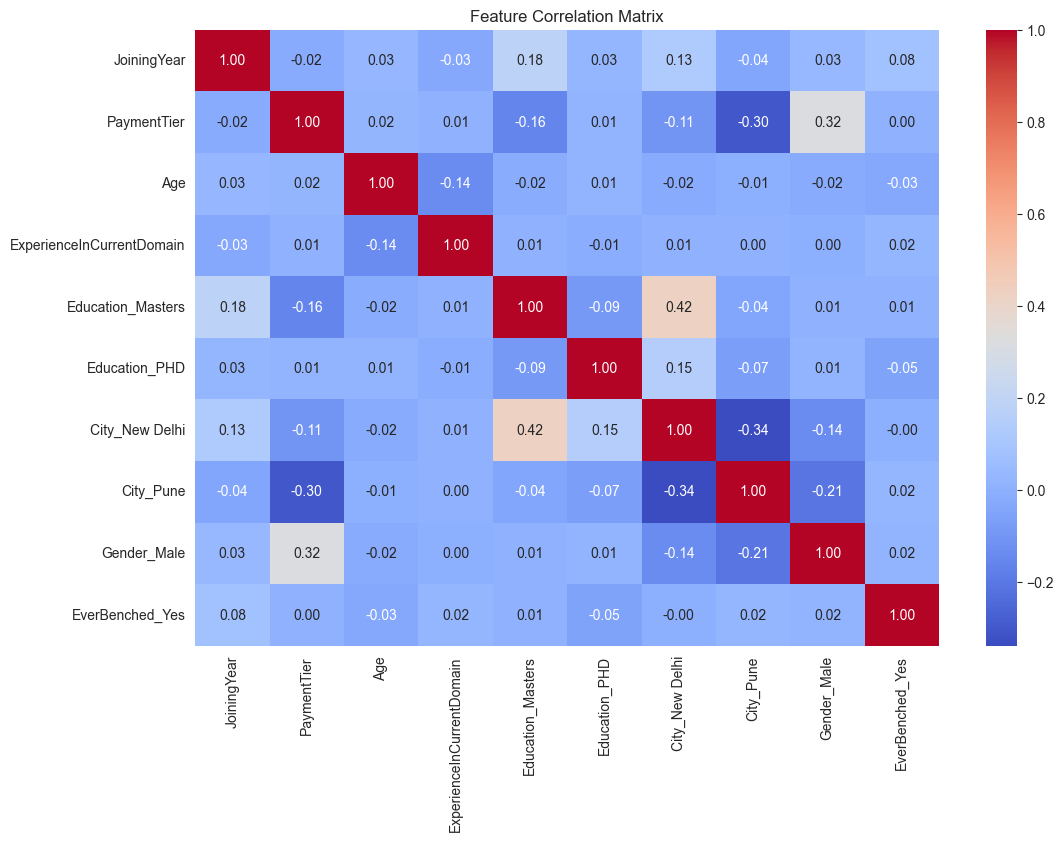

In [38]:
def plot_correlation_matrix(X):
    plt.figure(figsize=(12, 8))
    corr_matrix = X.corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title("Feature Correlation Matrix")
    plt.show()
    return corr_matrix

corr_matrix = plot_correlation_matrix(X)

In [39]:
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return X.drop(columns=to_drop)

X = remove_highly_correlated_features(X)
print(f"Pozostałe cechy po usunięciu wysoko skorelowanych: {X.columns.tolist()}")

Pozostałe cechy po usunięciu wysoko skorelowanych: ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain', 'Education_Masters', 'Education_PHD', 'City_New Delhi', 'City_Pune', 'Gender_Male', 'EverBenched_Yes']


In [40]:
def manual_train_test_split(X, y, test_size=0.2, random_state=10):
    np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

X_train, X_test, y_train, y_test = manual_train_test_split(X, y, test_size=0.2, random_state=10)

In [41]:
models = {
    'RandomForest': RandomForestClassifier(random_state=10),
    'SVM': SVC(probability=True, random_state=10),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=10),
    'LightGBM': LGBMClassifier(random_state=10)
}

In [42]:
param_spaces = {
    'RandomForest': {
        'n_estimators': (10, 200),
        'max_depth': (1, 20)
    },
    'SVM': {
        'C': (0.1, 10),
        'gamma': (0.01, 1)
    },
    'XGBoost': {
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 10)
    },
    'LightGBM': {
        'learning_rate': (0.01, 0.3),
        'num_leaves': (20, 50)
    }
}

In [43]:
def evaluate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return np.mean(scores)

In [44]:
from tqdm import tqdm

def genetic_optimization(model, param_space, X_train, y_train, n_gen=10, pop_size=20):
    fitness_history = []

    def create_individual():
        return [
            random.uniform(*param_space[key]) if key not in ['C', 'gamma', 'learning_rate'] else
            random.uniform(max(param_space[key][0], 1e-5), param_space[key][1])
            for key in param_space
        ]

    def mutate(individual):
        for i in range(len(individual)):
            if random.random() < 0.2:  # 20% mutation probability
                param_key = list(param_space.keys())[i]
                min_val, max_val = param_space[param_key]
                min_val = max(min_val, 1e-5) if param_key in ['C', 'gamma', 'learning_rate'] else min_val
                individual[i] = random.uniform(min_val, max_val)
        return individual,

    def evaluate_individual(individual):
        try:
            params = {
                key: (
                    max(int(individual[i]), 1) if key in ['n_estimators', 'max_depth', 'num_leaves'] else
                    max(individual[i], 1e-5) if key in ['C', 'gamma', 'learning_rate'] else
                    individual[i]
                )
                for i, key in enumerate(param_space.keys())
            }
            model.set_params(**params)
            score = evaluate_model(model, X_train, y_train)
            return (score,)
        except Exception as e:
            print(f"Error during evaluation: {e}")
            return (0,)

    if not hasattr(creator, "FitnessMax"):
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", mutate)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate_individual)

    population = toolbox.population(n=pop_size)
    for gen in tqdm(range(n_gen), desc="Genetic Optimization", unit="generation"):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
        fits = list(toolbox.map(toolbox.evaluate, offspring))
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))
        best_fit = max(ind.fitness.values[0] for ind in population)
        fitness_history.append(best_fit)

    best_individual = tools.selBest(population, k=1)[0]
    best_params = {
        key: (
            max(int(best_individual[i]), 1) if key in ['n_estimators', 'max_depth', 'num_leaves'] else
            max(best_individual[i], 1e-5) if key in ['C', 'gamma', 'learning_rate'] else
            best_individual[i]
        )
        for i, key in enumerate(param_space.keys())
    }
    return best_params, fitness_history


In [45]:
best_params = {}
fitness_histories = {}
results = {}

# Optimize models
for model_name, model in models.items():
    print(f"\nOptimizing {model_name}")
    param_space = param_spaces[model_name]
    optimized_params, fitness_history = genetic_optimization(model, param_space, X_train, y_train)
    best_params[model_name] = optimized_params
    fitness_histories[model_name] = fitness_history
    print(f"Best parameters for {model_name}: {optimized_params}")

# Evaluate models
for model_name, model in models.items():
    model.set_params(**best_params[model_name])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[model_name] = {'Accuracy': accuracy, 'F1 Score': f1}
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


Optimizing RandomForest


Genetic Optimization: 100%|██████████| 10/10 [02:13<00:00, 13.36s/generation]


Best parameters for RandomForest: {'n_estimators': 105, 'max_depth': 15}

Optimizing SVM


Genetic Optimization: 100%|██████████| 10/10 [15:15<00:00, 91.53s/generation]


Best parameters for SVM: {'C': 14.400969692951833, 'gamma': 0.6624416662652293}

Optimizing XGBoost


Genetic Optimization: 100%|██████████| 10/10 [02:24<00:00, 14.43s/generation]


Best parameters for XGBoost: {'learning_rate': 0.12656727767841405, 'max_depth': 7}

Optimizing LightGBM


Genetic Optimization:   0%|          | 0/10 [00:00<?, ?generation/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4132, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504840 -> initscore=0.019362
[LightGBM] [Info] Start training from score 0.019362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Genetic Optimization:  10%|█         | 1/10 [00:49<07:22, 49.19s/generation]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4132, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504840 -> initscore=0.019362
[LightGBM] [Info] Start training from score 0.019362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Genetic Optimization:  20%|██        | 2/10 [01:32<06:06, 45.82s/generation]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4132, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504840 -> initscore=0.019362
[LightGBM] [Info] Start training from score 0.019362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Genetic Optimization:  30%|███       | 3/10 [02:11<04:57, 42.46s/generation]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4132, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504840 -> initscore=0.019362
[LightGBM] [Info] Start training from score 0.019362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Genetic Optimization:  40%|████      | 4/10 [02:47<03:59, 39.96s/generation]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4132, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504840 -> initscore=0.019362
[LightGBM] [Info] Start training from score 0.019362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Genetic Optimization:  50%|█████     | 5/10 [03:20<03:06, 37.37s/generation]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4132, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504840 -> initscore=0.019362
[LightGBM] [Info] Start training from score 0.019362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Genetic Optimization:  60%|██████    | 6/10 [03:48<02:16, 34.24s/generation]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4132, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504840 -> initscore=0.019362
[LightGBM] [Info] Start training from score 0.019362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Genetic Optimization:  70%|███████   | 7/10 [04:12<01:33, 31.13s/generation]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4132, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504840 -> initscore=0.019362
[LightGBM] [Info] Start training from score 0.019362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Genetic Optimization:  80%|████████  | 8/10 [04:42<01:01, 30.80s/generation]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4132, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504840 -> initscore=0.019362
[LightGBM] [Info] Start training from score 0.019362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Genetic Optimization:  90%|█████████ | 9/10 [05:09<00:29, 29.34s/generation]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 4132, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504840 -> initscore=0.019362
[LightGBM] [Info] Start training from score 0.019362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2086, number of negative: 2046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

Genetic Optimization: 100%|██████████| 10/10 [05:35<00:00, 33.56s/generation]


Best parameters for LightGBM: {'learning_rate': 0.20523583479967938, 'num_leaves': 16}
Model: RandomForest, Accuracy: 0.8823, F1 Score: 0.8818
Model: SVM, Accuracy: 0.8466, F1 Score: 0.8464
Model: XGBoost, Accuracy: 0.8861, F1 Score: 0.8856
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2607, number of negative: 2558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 5165, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504743 -> initscore=0.018974
[LightGBM] [Info] Start training from score 0.018974
Model: LightGBM, Accuracy: 0.8799, F1 Score: 0.8794


In [48]:
import pandas as pd
from prettytable import PrettyTable

# Reference data
reference_data = {
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "SVM",
        "XGBoost",
        "LightGBM",
        "Voting Classifier",
        "Stacking Classifier"
    ],
    "Mean Accuracy": [
        0.6954748640864474, 
        0.8712808128673621, 
        0.8155169271426619, 
        0.8793357442451072, 
        0.8708167763008012, 
        0.833485094474008, 
        0.8681827992316418
    ],
    "Mean F1 Score": [
        0.6871011207462543, 
        0.8667302041268503, 
        0.8018958244042649, 
        0.8734245896745421, 
        0.8615925480935089, 
        0.8235683907169266, 
        0.8619265370925115
    ]
}

# Optimized results
optimized_results = {
    "Model": list(results.keys()),
    "Mean Accuracy": [results[model]["Accuracy"] for model in results],
    "Mean F1 Score": [results[model]["F1 Score"] for model in results],
}

# Convert to DataFrame
reference_df = pd.DataFrame(reference_data)
optimized_df = pd.DataFrame(optimized_results)

# Merge DataFrames
comparison_df = pd.merge(reference_df, optimized_df, on="Model", suffixes=("_Reference", "_Optimized"))

# Calculate differences
comparison_df["Accuracy Diff"] = (
    comparison_df["Mean Accuracy_Optimized"] - comparison_df["Mean Accuracy_Reference"]
)
comparison_df["F1 Score Diff"] = (
    comparison_df["Mean F1 Score_Optimized"] - comparison_df["Mean F1 Score_Reference"]
)

# Identify the best model in the optimized results
best_model = comparison_df.loc[
    comparison_df["Mean F1 Score_Optimized"].idxmax()
]

# Display comparison table
comparison_table = PrettyTable()
comparison_table.field_names = [
    "Model",
    "Ref Accuracy",
    "Opt Accuracy",
    "Accuracy Diff",
    "Ref F1 Score",
    "Opt F1 Score",
    "F1 Score Diff"
]

for _, row in comparison_df.iterrows():
    comparison_table.add_row([
        row["Model"],
        f"{row['Mean Accuracy_Reference']:.4f}",
        f"{row['Mean Accuracy_Optimized']:.4f}",
        f"{row['Accuracy Diff']:+.4f}",
        f"{row['Mean F1 Score_Reference']:.4f}",
        f"{row['Mean F1 Score_Optimized']:.4f}",
        f"{row['F1 Score Diff']:+.4f}"
    ])

print(comparison_table)

# Display the best model
print("\nBest Optimized Model:")
print(f"Model: {best_model['Model']}")
print(f"F1 Score: {best_model['Mean F1 Score_Optimized']:.2%}")
print(f"Accuracy: {best_model['Mean Accuracy_Optimized']:.2%}")

+----------+--------------+--------------+---------------+--------------+--------------+---------------+
|  Model   | Ref Accuracy | Opt Accuracy | Accuracy Diff | Ref F1 Score | Opt F1 Score | F1 Score Diff |
+----------+--------------+--------------+---------------+--------------+--------------+---------------+
|   SVM    |    0.8155    |    0.8466    |    +0.0311    |    0.8019    |    0.8464    |    +0.0445    |
| XGBoost  |    0.8793    |    0.8861    |    +0.0068    |    0.8734    |    0.8856    |    +0.0122    |
| LightGBM |    0.8708    |    0.8799    |    +0.0091    |    0.8616    |    0.8794    |    +0.0178    |
+----------+--------------+--------------+---------------+--------------+--------------+---------------+

Best Optimized Model:
Model: XGBoost
F1 Score: 88.56%
Accuracy: 88.61%


In [46]:
def plot_fitness_history(fitness_history, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fitness_history, marker='o', label=model_name)
    plt.title(f'Postęp optymalizacji genetycznej: {model_name}')
    plt.xlabel('Iteracja')
    plt.ylabel('Średni F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_model_comparison(results):
    labels = list(results.keys())
    f1_scores = [results[model]['F1 Score'] for model in labels]
    accuracies = [results[model]['Accuracy'] for model in labels]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, f1_scores, width, label='F1 Score', color='blue')
    ax.bar(x + width/2, accuracies, width, label='Accuracy', color='orange')

    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Models Results Comparision')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(indices)), importance[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
        plt.title(f"Features Importance: {model_name}")
        plt.xlabel('feature')
        plt.ylabel('weight')
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature importances.")


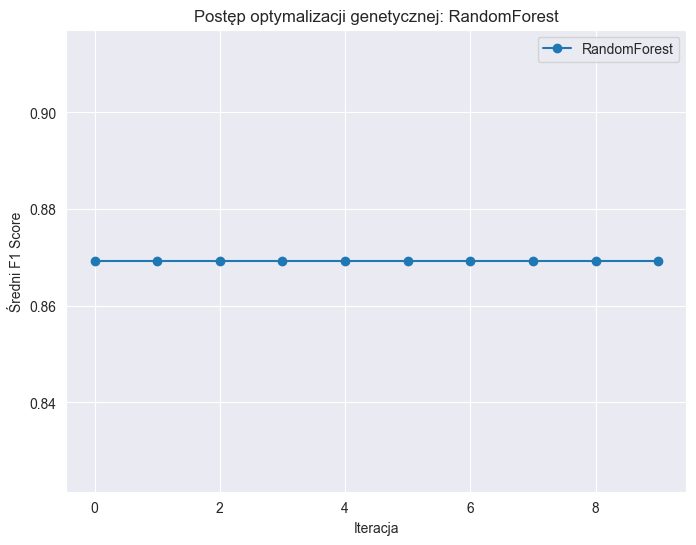

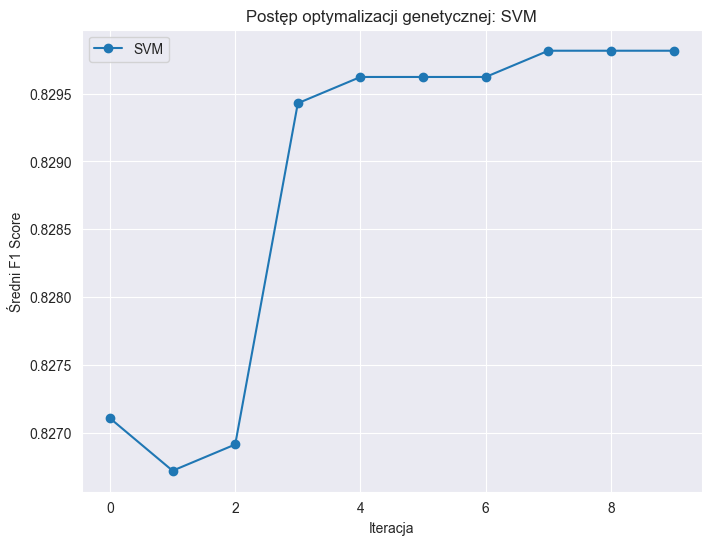

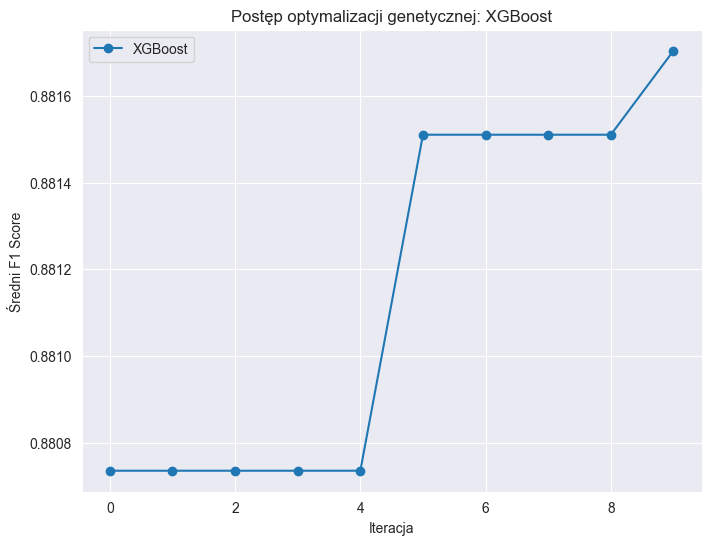

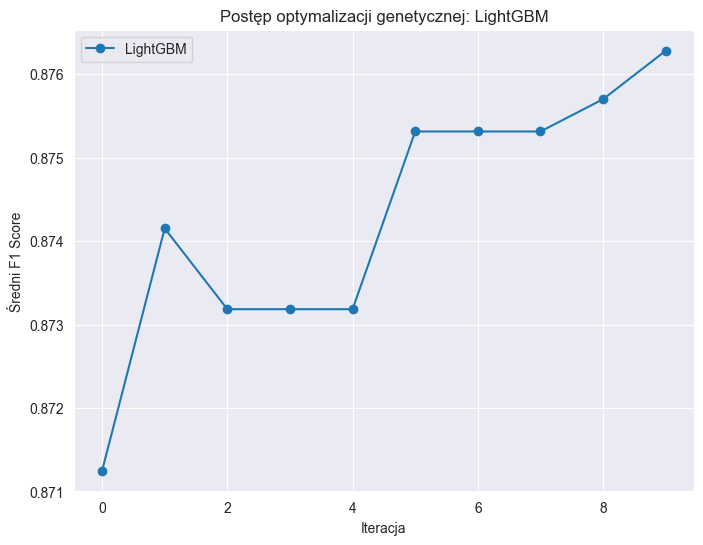

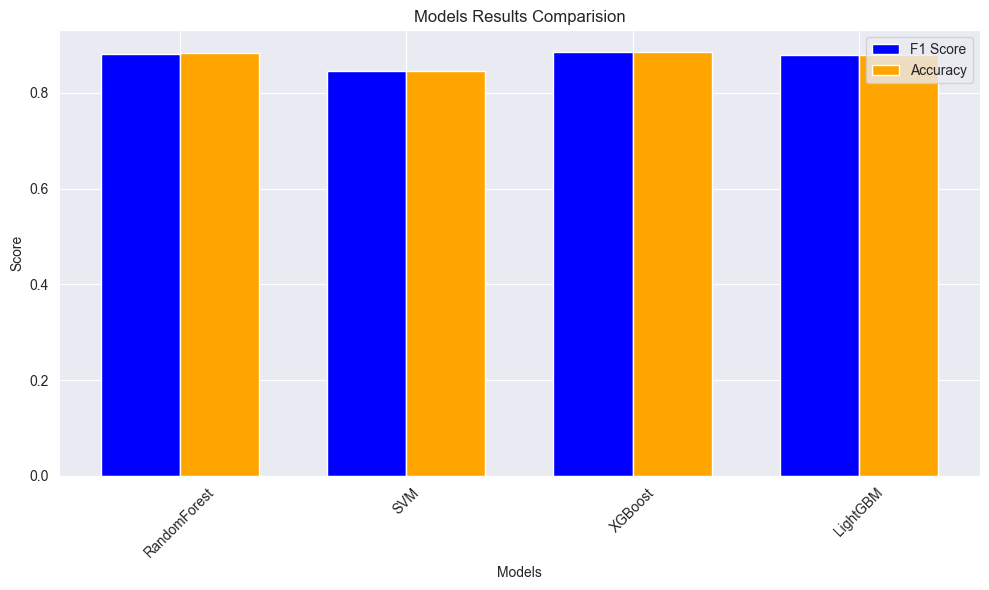


Best model: XGBoost


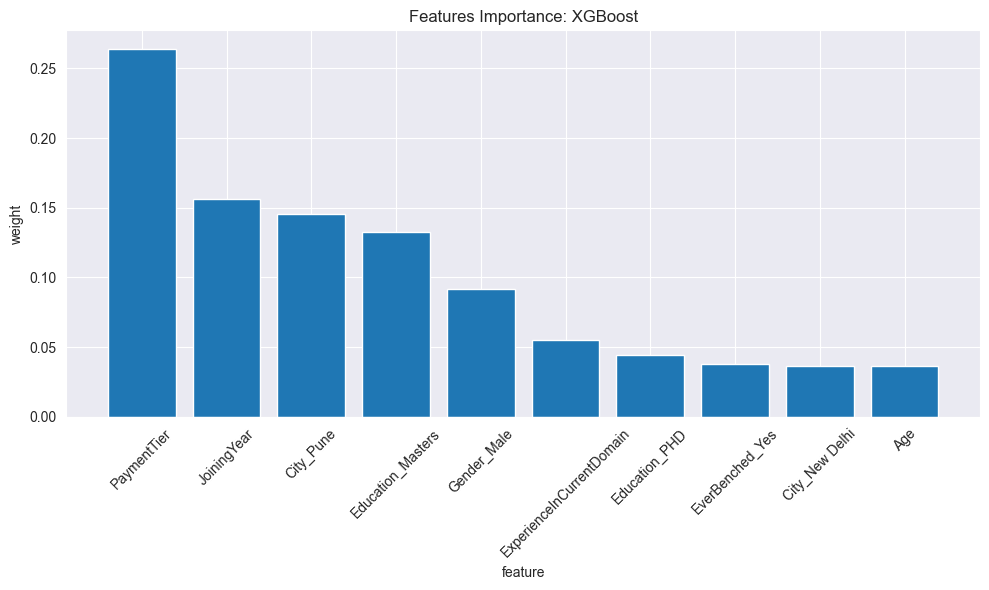

In [47]:
for model_name, history in fitness_histories.items():
    plot_fitness_history(history, model_name)

# Compare models
plot_model_comparison(results)

# Select best model
best_model_name = max(results, key=lambda x: results[x]['F1 Score'])
best_model = models[best_model_name]

print(f"\nBest model: {best_model_name}")
if best_model_name in ['XGBoost', 'LightGBM', 'RandomForest']:
    plot_feature_importance(best_model, X.columns, best_model_name)
else:
    print(f"Model {best_model_name} does not support feature importances.")